<a href="https://colab.research.google.com/github/mpaomend/g6_aprendizajeautomaticoico_s3/blob/main/colab/g6_aprendizajeautomaticoico_s3_KMEANS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Parte 1: Preparación del entorno
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud

In [6]:
#parte 2.- Cargar el Dataset
df = pd.read_csv("https://raw.githubusercontent.com/ancantos99/g6_aprendizajeautomaticoico_s3/refs/heads/main/dataset/dataset_procesado.csv")
print (df.head())
print(df.shape)

#NORMAILIZAR DATOS PARA CLUSTERING
columnas = ['Impresiones', 'Clicks', 'CostoxClick', 'TasaClicks']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[columnas])

           TerminoBusqueda                    Match type  Impresiones  Clicks  \
0                  copilot                   Broad match         2060      47   
1  inteligencia artificial                   Broad match          694      20   
2              blackbox ai  Phrase match (close variant)          670      25   
3                  copilot                   Broad match          388       2   
4  inteligência artificial                   Broad match          312      23   

   CostoxClick            Keyword  TasaClicks  
0         0.10          coding ai    0.022816  
1         0.24        ai programs    0.028818  
2         0.20        ai software    0.037313  
3         0.31  AI software tools    0.005155  
4         0.31        ai programs    0.073718  
(14402, 7)


# **K-MEANS**
Método del codo para encontrar el mejor valor para k

El mejor valor de K viene determinado por donde comienza a girar la curva, puede ser 4 o 5 en nuestro caso

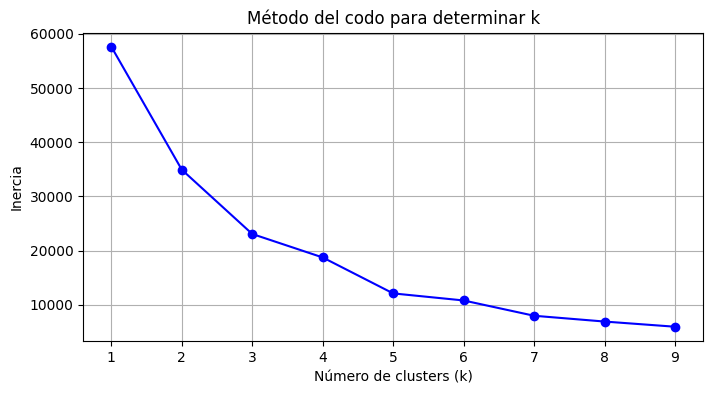

In [7]:
#IMPLEMENTACIÓN DE K-MEANS
#MÉTODO DEL CODO PARA ENCONTRAR EL MEJOR VALOR PARA K
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar k')
plt.grid(True)
plt.show()

**Entrenar el modelo**

unque tanto con k = 4 como con k = 5 tienes un cluster con un solo elemento (Sería un outlier), con k = 5 obtengo una mejor segmentación del resto de los datos, ya que:

- Permite dividir mejor los otros grupos.

- El cluster de un solo elemento se puede tratar como ruido o dato atípico, sin afectar la interpretación de los demás grupos.

In [8]:
# ENTRENAR MODELO CON K = 4 y 5
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Ver cuántos elementos hay en cada cluster
print(df['Cluster'].value_counts())

Cluster
0    13084
3      763
1      535
4       19
2        1
Name: count, dtype: int64


**ESTOS RESULTADOS SE PUEDEN INTERPRETAR DE LA SIGUIENTE MANERA**

CLUSTER 3, Tiente más tasa de clicks promedio (PALABRAS O FRASES QUE GENERAN ALTA EFICIENCIA)

CLUSTER 2. Tiene más impresiones y Clicks (PALABRAS O FRASES QUE GENERAN ALTA VISIBILIDAD)

Pero en este Cluster solo hay 1 elemento, por lo que el CLUSTER 4 PODRÍA CONSIDERARLO COMO MI CLUSTER CON MÁS VISIBILIDAD

CLUSTER 1. Tiemen mayor Costo Promedio por Click (PALABRAS MÁS CARAS)

In [ ]:
# Promedios por cluster
cluster_summary = df.groupby('Cluster')[['Impresiones', 'Clicks', 'CostoxClick', 'TasaClicks']].mean()
print(cluster_summary)


         Impresiones     Clicks  CostoxClick  TasaClicks
Cluster                                                 
0           1.918374   0.025604     0.002719    0.003919
1          13.869159   1.800000     0.480430    0.366942
2        2060.000000  47.000000     0.100000    0.022816
3           1.314548   1.090433     0.223827    0.913150
4         200.105263  18.105263     0.279474    0.132059


# **DBSCAN**

Agrupaciones densas de puntos sin necesidad de conocer cuantos cluster tienen.

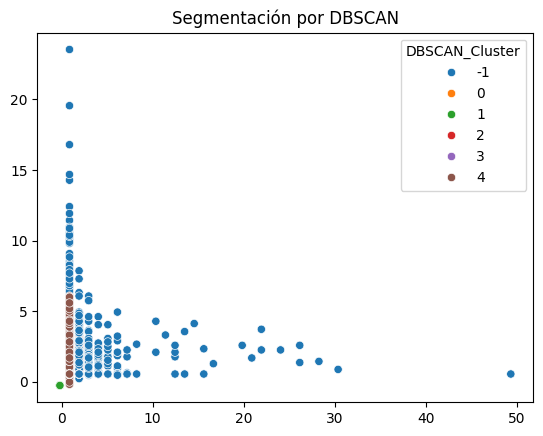

In [9]:
# IMPLEMENTACIÓN DE BDSCAN
# CON eps 0.6 y min_samples 108
dbscan = DBSCAN(eps=0.6, min_samples=10)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()

Entrenar el modelo

Con eps=0.8 y min_samples=15, el modelo DBSCAN generó clústeres más definidos y menos ruido, mejorando la agrupación de datos relevantes. Comparado con eps=0.6 y min_samples=10, el segundo entrenamiento ofrece mejor estabilidad y segmentación más precisa.

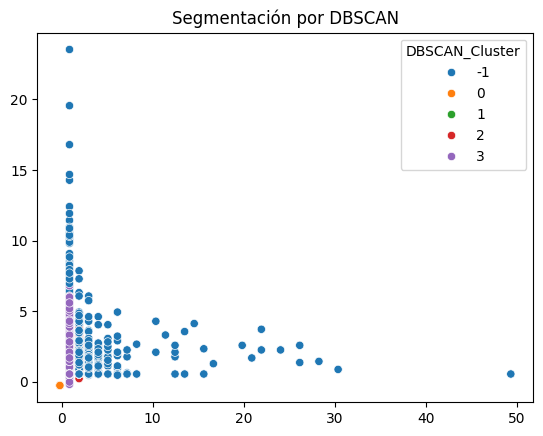

In [10]:
# IMPLEMENTACIÓN DE BDSCAN
# CON eps 0.8 y min_samples 15
dbscan = DBSCAN(eps=0.8, min_samples=15)
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], hue=df['DBSCAN_Cluster'], palette='tab10')
plt.title('Segmentación por DBSCAN')
plt.show()

**ESTOS RESULTADOS SE PUEDEN INTERPRETAR DE LA SIGUIENTE MANERA**

Clúster -1: Mayor volumen de tráfico con buen TasaClicks (44.6%) pero CostoxClick más alto (0.45); no fue agrupado, posiblemente por comportamiento variado.

Clúster 0: Sin clics y sin efectividad; tráfico irrelevante.

Clúster 1: Rendimiento aceptable con TasaClicks del 28.9% y CostoxClick moderado (0.25).

Clúster 2: Mejor eficiencia costo-beneficio con bajo CostoxClick (0.21) y buen TasaClicks (27%).

Clúster 3: TasaClicks perfecto (100%) pero basado en un solo caso; no representativo.

In [13]:
# INTERPRETACION DEL CLUSTERING CON DBSCAN CON VALORES ATÍPICOS
df['DBSCAN_Cluster'].value_counts()
df.groupby('DBSCAN_Cluster')[['Impresiones', 'Clicks', 'CostoxClick', 'TasaClicks']].mean()

,Impresiones,Clicks,CostoxClick,TasaClicks
DBSCAN_Cluster,,,,
-1,50.576763,4.33195,0.452656,0.445895
0,1.662834,0.00000,0.000000,0.000000
1,6.400616,1.00000,0.250755,0.289368
2,11.343137,2.00000,0.213627,0.270499
3,1.000000,1.00000,0.280737,1.000000


In [12]:
# INTERPRETACION DEL CLUSTERING CON DBSCAN SIN VALORES ATÍPICOS
df_no_noise = df[df['DBSCAN_Cluster'] != -1]
df_no_noise.groupby('DBSCAN_Cluster')[['Impresiones', 'Clicks', 'CostoxClick', 'TasaClicks']].mean()

,Impresiones,Clicks,CostoxClick,TasaClicks
DBSCAN_Cluster,,,,
0,1.662834,0.0,0.000000,0.000000
1,6.400616,1.0,0.250755,0.289368
2,11.343137,2.0,0.213627,0.270499
3,1.000000,1.0,0.280737,1.000000


# **PCA**
PCA (Análisis de Componentes Principales) es una técnica lineal de reducción de dimensionalidad que transforma los datos en nuevas variables ortogonales (componentes principales), conservando la mayor variabilidad posible con menos dimensiones.
El Cluster 2 es un outliers que distorsionan la escala

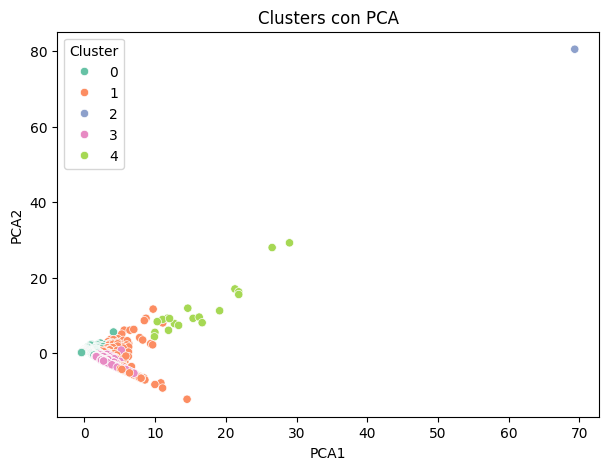

In [14]:
#Visualización 2D con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Agregar al DataFrame
df['PCA1'] = X_pca[:, 0]
df['PCA2'] = X_pca[:, 1]

# Plot
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Clusters con PCA')
plt.show()

**REDUCCIÓN DE DIMENSIONALIDAD**

Se seleccionarán los registros cuyos valores en las componentes principales PCA1 y PCA2 sean menores a 40

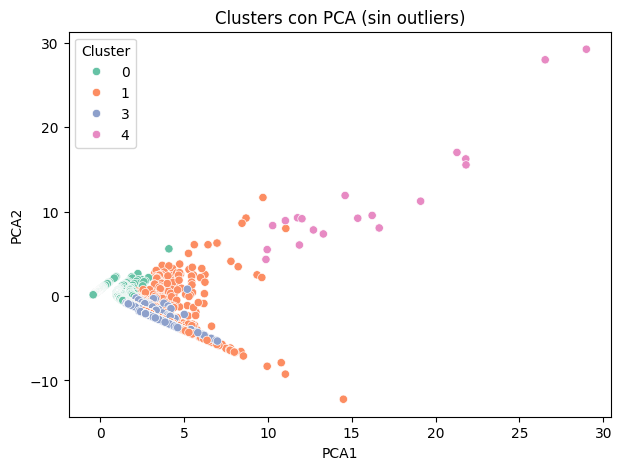

In [15]:
df_filtered = df[(df['PCA1'] < 40) &
                 (df['PCA2'] < 40)]

plt.figure(figsize=(7, 5))
sns.scatterplot(data=df_filtered, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Clusters con PCA (sin outliers)')
plt.show()

# **t-SNE**
Técnica avanzada de reducción de dimensionalidad no lineal, diseñada específicamente para la visualización de datos complejos en espacios de 2D o 3D

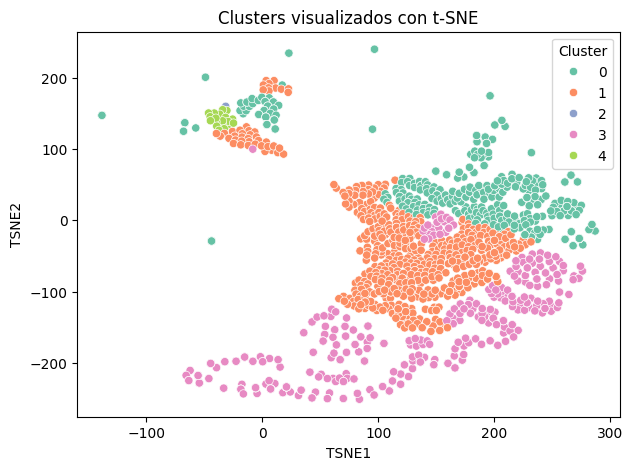

In [17]:
#Reducción de dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_tsne = tsne.fit_transform(X_scaled)

# Agregar al DataFrame
df['TSNE1'] = X_tsne[:, 0]
df['TSNE2'] = X_tsne[:, 1]

# Visualizar
plt.figure(figsize=(7, 5))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='Cluster', palette='Set2')
plt.title('Clusters visualizados con t-SNE')
plt.show()

**ESTOS RESULTADOS SE PUEDEN INTERPRETAR DE LA SIGUIENTE MANERA**

Cluster 0: Términos emergentes con bajo volumen y buena  Tasa de Clicks, relacionados a herramientas nuevas de IA.

Cluster 1: Alta efectividad con términos de nicho centrados en IA gratuita y creativa, ideal para captar usuarios interesados.

Cluster 2: Único término de altísimo volumen (copilot) con  Tasa de Clicks muy baja, orientado a awareness más que conversión.

Cluster 3: Alta conversión en términos educativos y prácticos de IA, con volumen moderado y excelente rendimiento.

Cluster 4: Términos amplios y genéricos con buen volumen pero  Tasa de Clicks moderados, útiles para captar audiencias grandes pero menos específicas.

In [18]:
#filtrar términos con al menos 10 impresiones para evitar sesgos
df_mostrarterminos = df[df['Impresiones'] >= 5]

# Mostrar los 5 mejores términos por cluster con mayor CTR
for c in sorted(df_mostrarterminos['Cluster'].unique()):
    print(f"\nCluster {c} - Top 5 términos con mayor Tasa de Clicks:\n")
    display(df_mostrarterminos[df_mostrarterminos['Cluster'] == c]
            .sort_values(by='TasaClicks', ascending=False)
            .loc[:, ['TerminoBusqueda', 'Impresiones', 'Clicks', 'CostoxClick', 'TasaClicks']]
            .head(5))


Cluster 0 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
798,https www decohere ai,6,2,0.1,0.333333
686,ai game generator,7,2,0.1,0.285714
696,yapay zeka görsel oluşturma,7,2,0.1,0.285714
647,kre ai,7,2,0.1,0.285714
614,leap ai,8,2,0.1,0.250000



Cluster 1 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
695,ia que cria imagens de graça,7,5,0.38,0.714286
899,app de inteligência artificial gratuito,5,3,0.39,0.600000
689,openai's musenet,7,4,0.53,0.571429
633,criar música com inteligência artificial grátis,7,4,0.29,0.571429
503,ia para programacao,9,5,0.53,0.555556



Cluster 2 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
0,copilot,2060,47,0.1,0.022816



Cluster 3 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
488,doctrina ai exam,9,6,0.09,0.666667
1073,ia para apresentação de slides,5,3,0.25,0.600000
924,ai project maker,5,3,0.10,0.600000
784,yazılım yapan yapay zeka,6,3,0.17,0.500000
884,creador de imagenes inteligencia artificial,5,2,0.10,0.400000



Cluster 4 - Top 5 términos con mayor Tasa de Clicks:



,TerminoBusqueda,Impresiones,Clicks,CostoxClick,TasaClicks
32,ia para programação,80,21,0.49,0.262500
56,inteligencia artificial gratis,50,12,0.35,0.240000
42,ia para criar slides gratuito,65,15,0.32,0.230769
24,ia para programação,115,25,0.35,0.217391
28,melhor ia para programação,103,21,0.31,0.203883


# **Gráficos comparativos**

**KMEANS y DBSCAN**

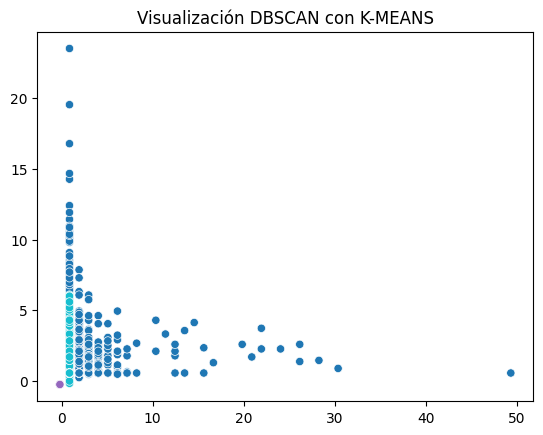

In [35]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

sns.scatterplot(x=X_scaled[:, 1], y=X_scaled[:, 2], c=df['DBSCAN_Cluster'], cmap='tab10')
plt.title('Visualización comparativa entre K-means y DBSCAN')
plt.show()

**2D de PCA y t-SNE**

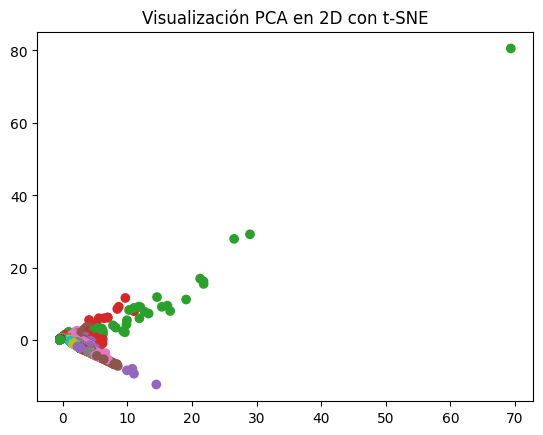

In [25]:
#Simulación PCA con t-SNE
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['TSNE1'], cmap='tab10')
plt.title('Visualización comparativa entre PCA en 2D con t-SNE')
plt.show()

**Tabla resumen de características medias por cluster**

In [45]:
print("Clusters únicos KMeans:", df['Cluster'].unique())
print("Clusters únicos DBSCAN:", df['DBSCAN_Cluster'].unique())
print("Clusters únicos PCA:", (df['PCA1'] < 40).unique())
print("Clusters únicos t-SNE:", df['TSNE1'].unique())

Clusters únicos KMeans: [2 4 1 0 3]
Clusters únicos DBSCAN: [-1  0  1  2  3  4]
Clusters únicos PCA: [False  True]
Clusters únicos t-SNE: [-31.653894 -30.610073 -34.28989  ...  63.1906   201.75027  115.041985]
